# Анализ оттока клиентов в сети фитнес-центров 

__Постановка задачи:__

Провести анализ и подготовить план действий по удержанию клиентов.

__Цель проекта:__

Разработать рекомендации по повышению качества работы с клиентами.

__План работ:__

1. Загрузка и предобработка данных
2. Исследовательский анализ данных
3. Модель прогнозирования оттока клиентов
4. Кластеризацию клиентов
5. Выводы и рекомендации по работе с клиентами

In [1]:
# подключение библиотек
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

large = 24; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 8),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': small,
          'ytick.labelsize': small,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

<a id='id_1'></a>
## Загрузка и предобработка данных

In [2]:
# получение данных
data = pd.read_csv('/datasets/gym_churn.csv', sep=',')
data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Приведем наименования полей к стандарту, проверим наличие дубликатов, отформатируем поля с датой и временем.

In [4]:
# проверка наименования полей
data.columns

Index(['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone',
       'Contract_period', 'Group_visits', 'Age',
       'Avg_additional_charges_total', 'Month_to_end_contract', 'Lifetime',
       'Avg_class_frequency_total', 'Avg_class_frequency_current_month',
       'Churn'],
      dtype='object')

In [5]:
# стандартизация наименования полей
data.columns = data.columns.str.lower()

In [6]:
# контроль наименования полей
data.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

In [7]:
# проверка наличия явных дубликатов
data.duplicated().sum()

0

In [8]:
# перевод номера месяца в целочисленный формат
data['month_to_end_contract'] = data['month_to_end_contract'].astype('int64')

In [9]:
# контроль формата данных и проверка их полноты
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   int64  
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

<a id='id_2'></a>
## Исследовательский анализ данных (EDA)

In [10]:
# обзор параметров данных
data.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


**Выводы**:

Ппропущенных данных нет. Анализ статистических данных показывает портрет типичного клиента:
- гендерных различий нет,
- 85% клиентов живут поблизости,
- почти половина клиентов работает в компаниях-партнерах,
- 30% пришли по рекомендации друзей,
- 90% оставили контактный телефон,
- 40% посещают групповые занятия,
- средний возраст 29 лет (ст.откл. 3года, медиана 29 лет, мин. 18 лет, макс 41 год),

Параметры типичных получаемых услуг:
- средний период контракта составляет 4,7 месяцав при этом медиана 1 мес. (3 квартиль - 5 мес., макс. - 12 мес.),
- средний доход от сопутствующих услуг 147 т.р. (ст.откл. 96 т.р., медиана 136, максимум 552),
- средний период до окончания контракта  4 мес. (ст.откл. 4 мес., медиана 1 мес., 3 квартиль 6 мес., макс. 12 мес.),
- средний  период жизни клиента 3,7 мес. (ст.откл.3.7 мес., медиана 3 мес, 3 квартиль 5 мес., макс. 31 мес.),
- среднее число посещений в неделю 1,9 раза (ст.откл 1, медиана 1,8, 3 квартиль 2.5, макс. 6),
- среднее число посещений в неделю в пред.месяце 1,8 раза (ст.откл 1.1, медиана 1.7, 3 квартиль 2.5, макс. 6.1),

В итоге отток текущего месяца составил 27%.

In [11]:
# сравнение средних значений признаков ушедших и оставшихся
data_group = data.groupby('churn').mean()
data_group

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


**Вывод**:

Среди ушедших клиентов:
- на 10% больше доля живущих в отдаленных районах,
- на 17% меньше работающих в компаниях-партнерах или пришедших по рекомендациям друзей,
- на 19% меньше посещающих групповые занятия.

У ушедших клиентов:
- на 17% меньше расходы на сопутствующие услуги ,
- средний период жизни 1 месяц против 4.7 месяцев у оставшихся,
- среднее количество посещений в неделю 1.5 против 2 у оставшихся,
- среднее количество посещений в последний месяц 1 против 2 у оставшихся.

In [12]:
# разделение числовы и категориальных полей
numeric = ['contract_period', 'age', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']
category = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']

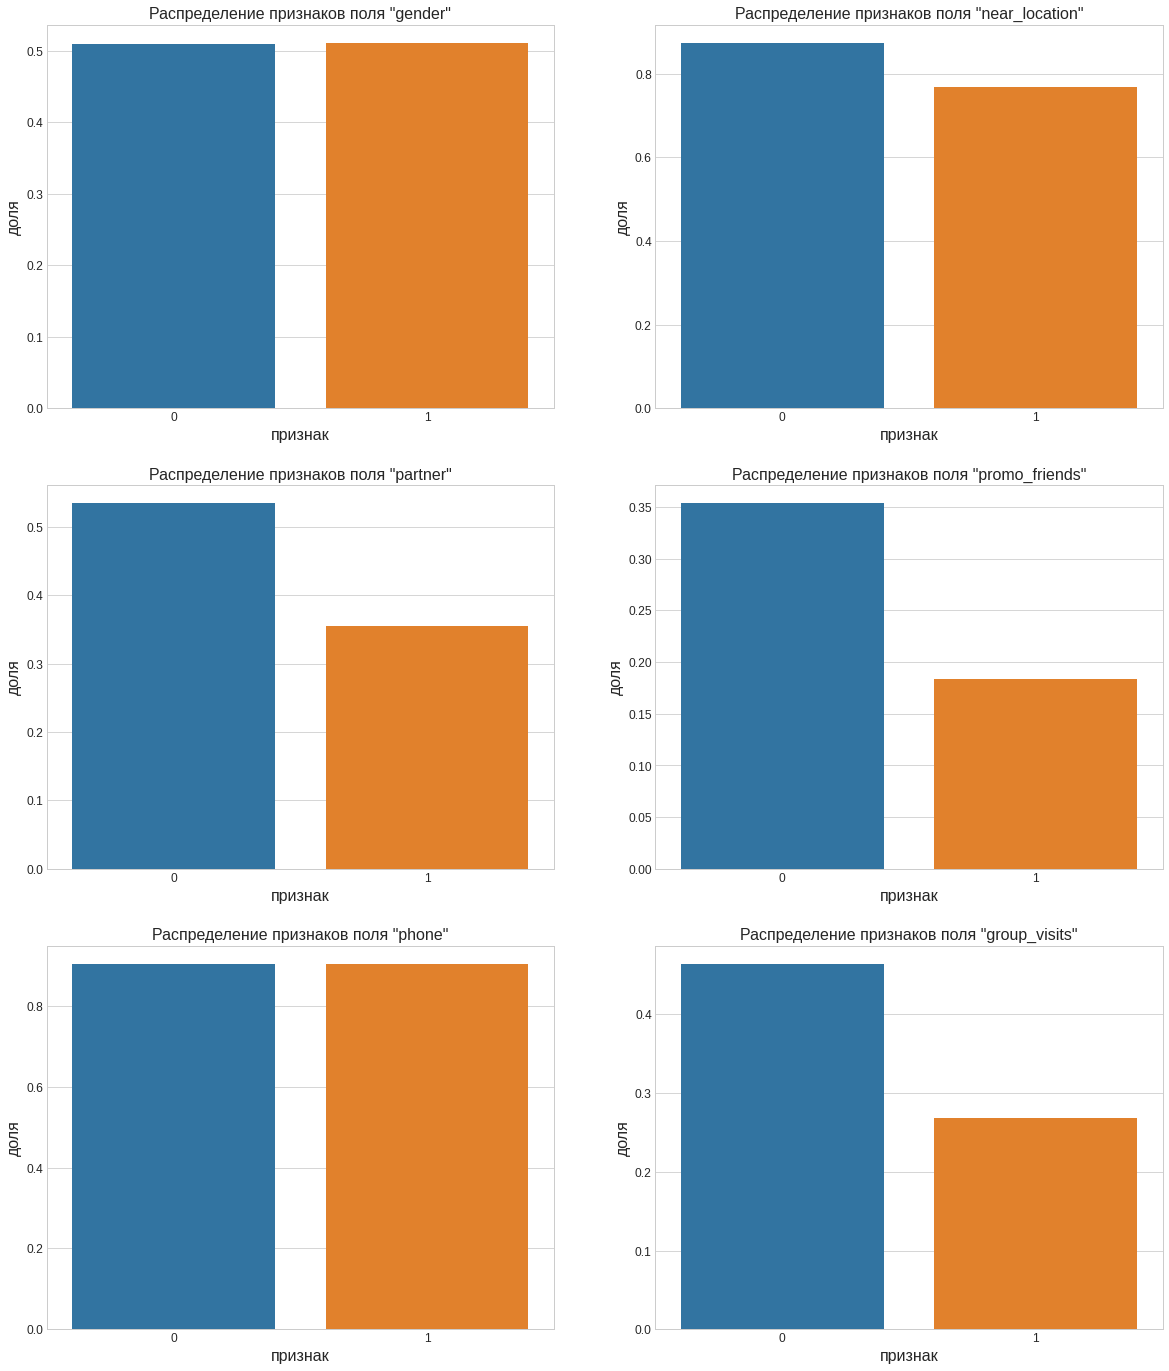

In [13]:
# диаграммы распределения признаков категориальных полей
f, ax = plt.subplots(3, 2, figsize=(20, 24))
for j, cat in enumerate(category):
    plt.subplot(3, 2, j+1)
    ax = sns.barplot(y=cat, x=data_group.index, data=data_group)
    ax.set_title('Распределение признаков поля "{}"'.format(cat))
    ax.set_xlabel('признак')
    ax.set_ylabel('доля')
plt.show();

**Выводы по категориальным полям:** гендерная составляющая анализируемых данных не отличается. Наиболее сильно различаются доли клиентов по признакам групповых занятий, пришедших по рекомендации друзей и работающих в компаниях-партнерах.

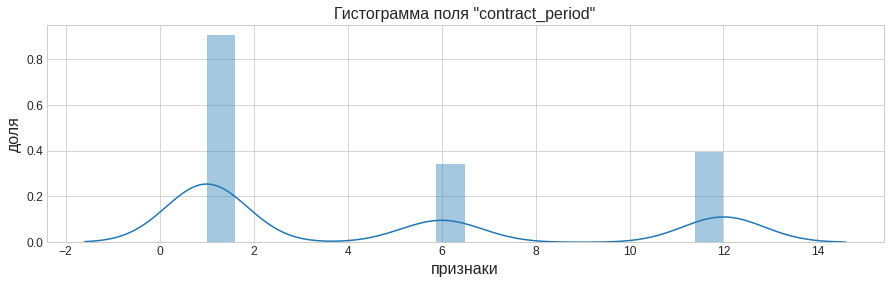

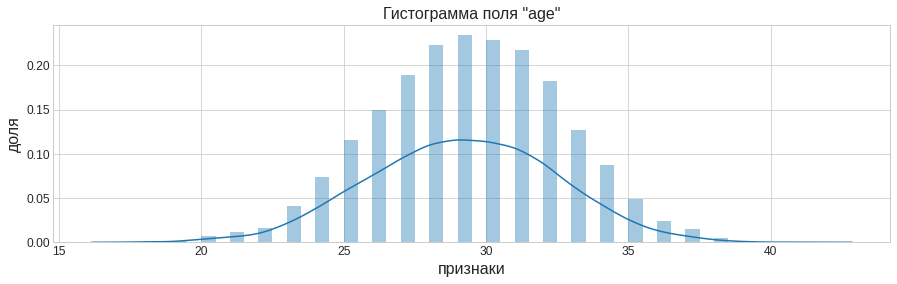

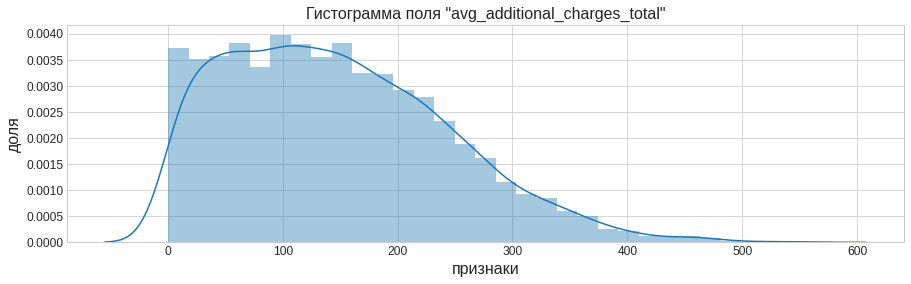

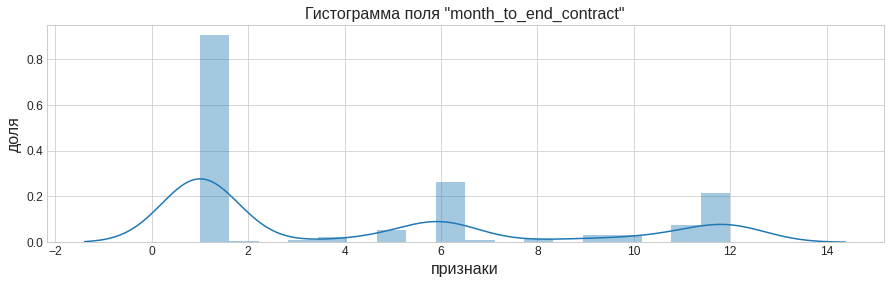

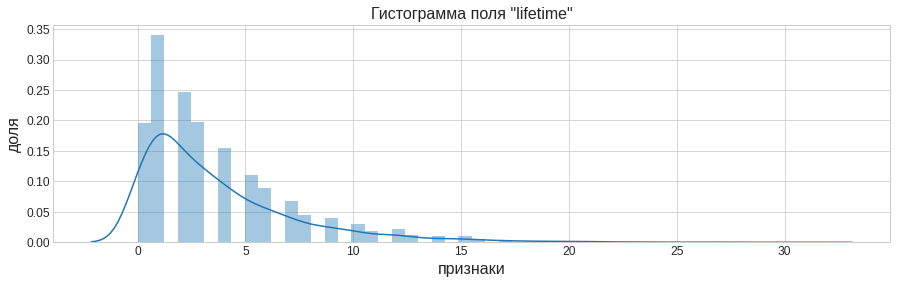

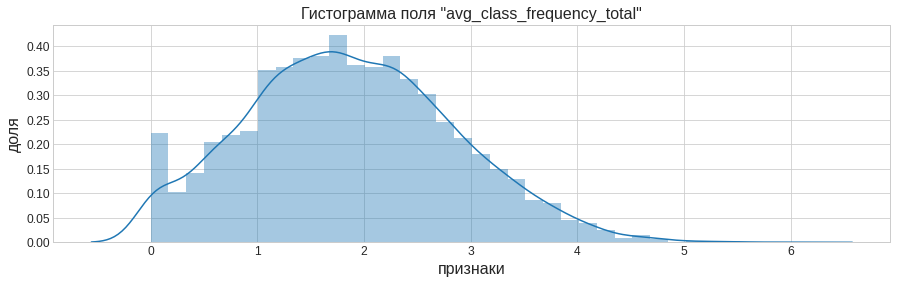

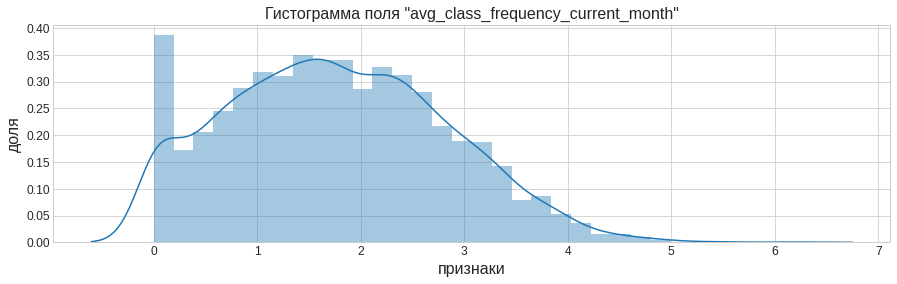

In [14]:
# диаграммы распределения признаков числовых полей
for num in numeric:
    f, ax = plt.subplots(figsize=(15, 4))
    ax = sns.distplot(data[num])
    ax.set_title('Гистограмма поля "{}"'.format(num))
    ax.set_xlabel('признаки')
    ax.set_ylabel('доля')
    plt.show();

**Выводы по числовым полям:** наибольшая доля клиентов занимается по одно-месячным контрактам, медиана срока посещения занятий составляет 2 месяца.

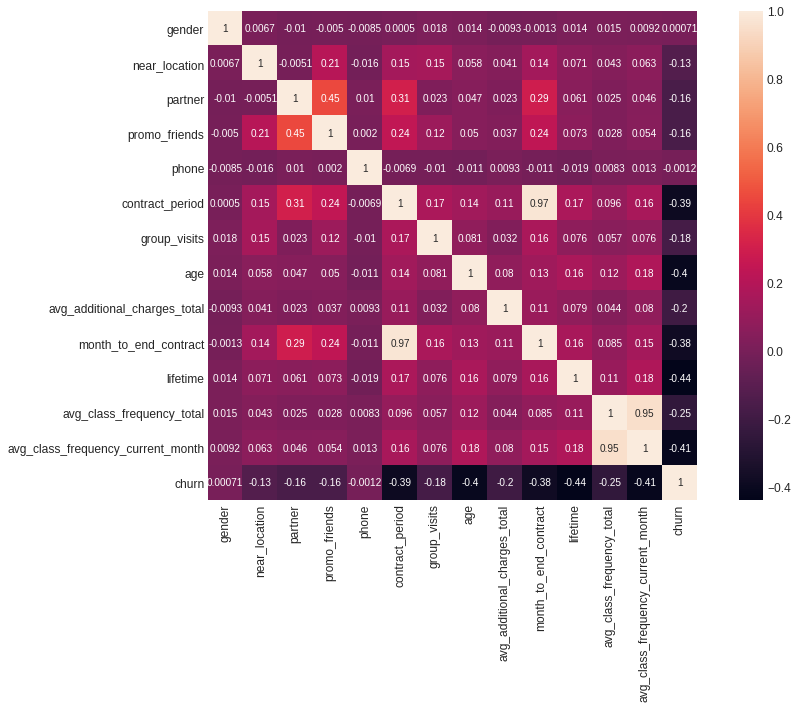

In [15]:
# анализ корреляции признаков
corr_var = data.corr()
f, ax = plt.subplots(figsize=(15, 9))
sns.heatmap(corr_var, annot=True, square=True);

**Выводы:** наибольшая корреляция ожидаемо наблюдается между количеством месяцев до окончания контракта и периодом контракта, а также между средней частой посещения занятий и средней частотой посещения занятий за предыдущий месяц. Существенная отрицательная корреляция наблюдается между показателями оттока и периодом посещения занятий, частотой посещения заниятий, возрастом и контрактным периодом.

<a id='id_3'></a>
## Модель прогнозирования оттока клиентов

In [16]:
# разделим данные на признаки и тестовую переменную
X = data.drop('churn', axis = 1)
y = data['churn']
# выделим обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# стандартизируем данные
scaler = StandardScaler()
scaler.fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

In [17]:
# функция оценки метрик accuracy, precision, recall
def false_metric(y_true, y_pred, name_model):
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    print(
        'Метрики модели {}:\
        acc = {:.2f}\
        precision = {:.2f}\
        recall = {:.2f}'.format(name_model, acc, precision, recall)
        )

In [18]:
# расчет метрик модели логистической регрессии
lr_model = LogisticRegression(solver='liblinear', random_state = 0)
lr_model.fit(X_train_st, y_train)
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)
false_metric(y_test, lr_predictions, 'логистической регрессии')

Метрики модели логистической регрессии:        acc = 0.92        precision = 0.85        recall = 0.83


In [19]:
# расчет метрик модели случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)
rf_model.fit(X_train_st, y_train)
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)
false_metric(y_test, rf_predictions, 'случайного леса')

Метрики модели случайного леса:        acc = 0.92        precision = 0.84        recall = 0.81


Выводы: метрики моделей схожи, выберем модель логистической регрессии, как показавшую чуть лучшие результаты.

<a id='id_4'></a>
## Кластеризация клиентов

Кластеризацию проведем в два этапа - вычислим иерархической кластеризацией оптимальное количество кластеров и используем метод алгоритма кластеризации K-means.

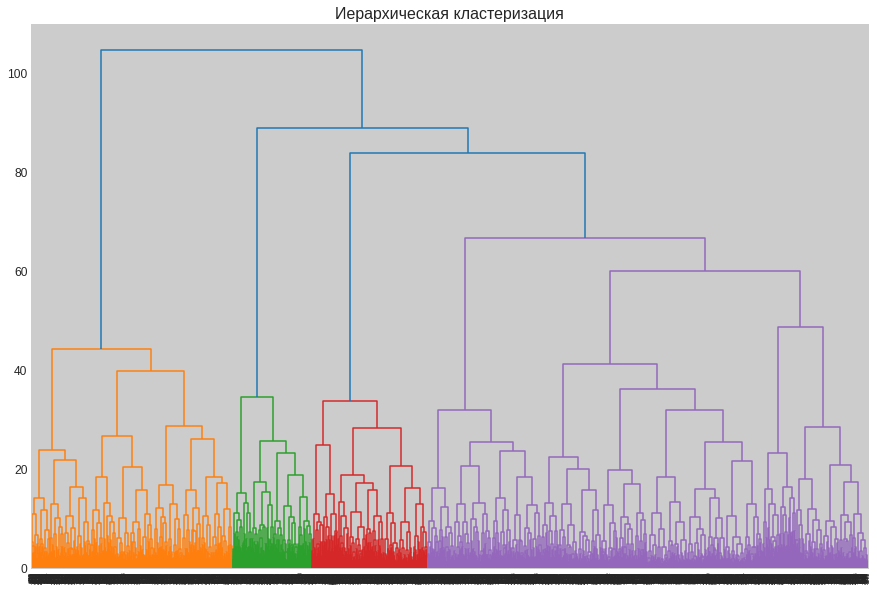

In [20]:
# стандартизируем данные
sc = StandardScaler()
X_sc = sc.fit_transform(X)
# построение матрицы расстояний
linked = linkage(X_sc, method = 'ward')
plt.figure(figsize=(15, 10))
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация')
plt.show()

Предложено оптимальное числло кластеров - 4. Примем число кластеров n=5.

In [21]:
# обучим модель кластеризации на основании алгоритма K-means (n=5)
km = KMeans(n_clusters=5, random_state=0)
labels = km.fit_predict(X_sc)
data['cluster_km'] = labels
print(data.groupby('cluster_km').mean())

              gender  near_location   partner  promo_friends     phone  \
cluster_km                                                               
0           0.502970       0.959406  0.783168       0.574257  1.000000   
1           0.522078       0.862338  0.470130       0.306494  0.000000   
2           0.495050       0.000000  0.463366       0.079208  1.000000   
3           0.485737       1.000000  0.350238       0.240095  1.000000   
4           0.559666       0.976134  0.356802       0.230310  0.998807   

            contract_period  group_visits        age  \
cluster_km                                             
0                 10.889109      0.542574  29.982178   
1                  4.787013      0.425974  29.301299   
2                  2.352475      0.215842  28.477228   
3                  1.948494      0.341521  28.167987   
4                  2.669451      0.473747  30.125298   

            avg_additional_charges_total  month_to_end_contract  lifetime  \
cluster_km 

In [24]:
# функция отрисовки графиков попарных числовых признаков
def show_clusters_on_plot(df, x_name, y_name, cluster_name):
    plt.figure(figsize=(5, 5))
    sns.scatterplot(
        df[x_name], df[y_name], hue=df[cluster_name], palette='Paired'
    )
    plt.title('{} vs {}'.format(x_name, y_name))
    plt.show()

In [25]:
# функция отрисовки графиков попарных категориальных признаков
def show_clusters_on_plot_сat(df, x_name, y_name, cluster_name):
    plt.figure(figsize=(20, 5))
    sns.barplot(
        df[x_name], df[y_name], hue=df[cluster_name], palette='Paired'
    )
    plt.title('{} vs {}'.format(x_name, y_name))
    plt.show()

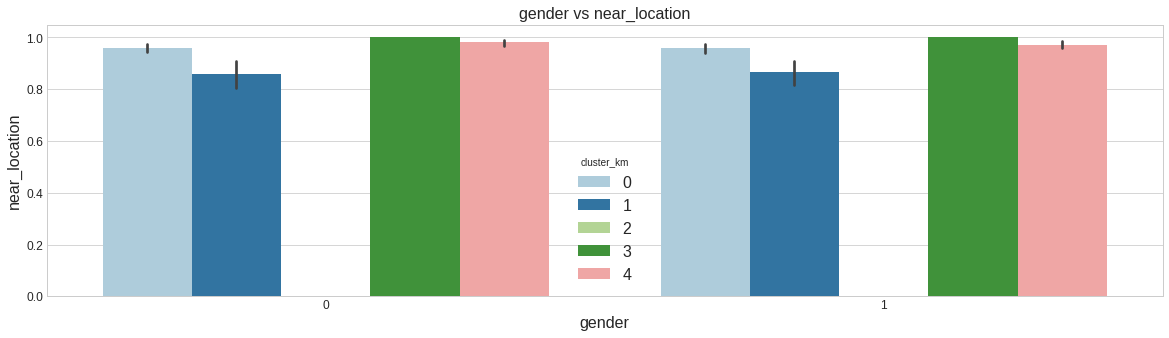

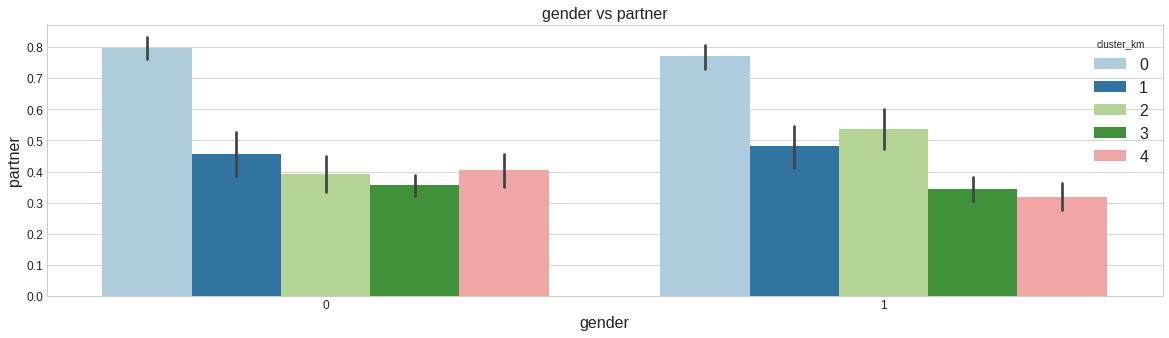

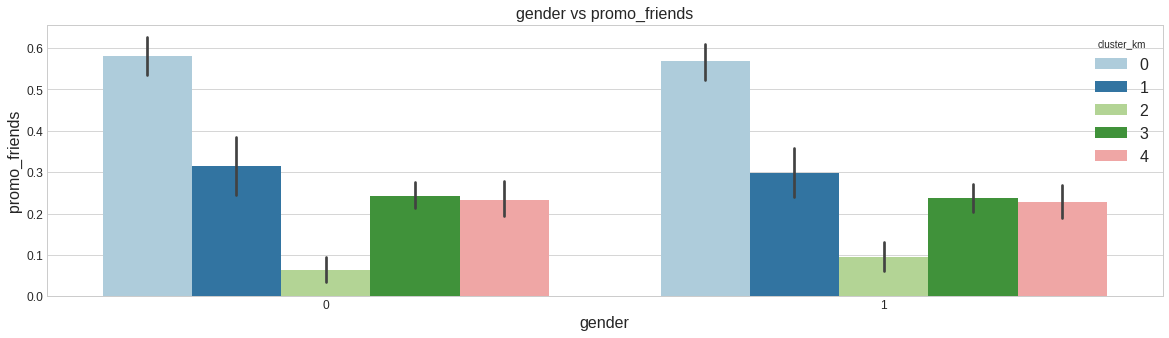

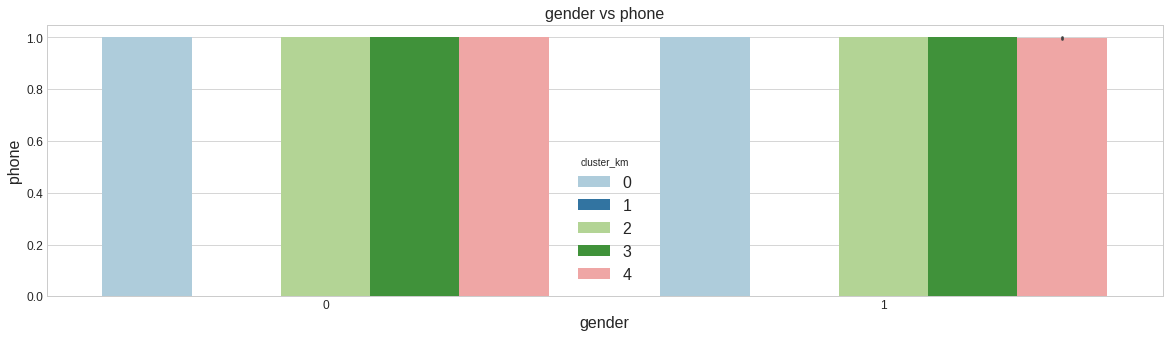

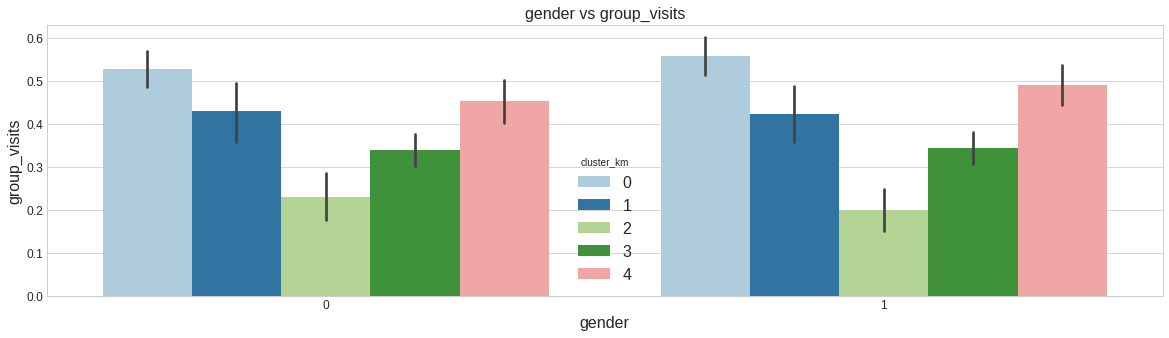

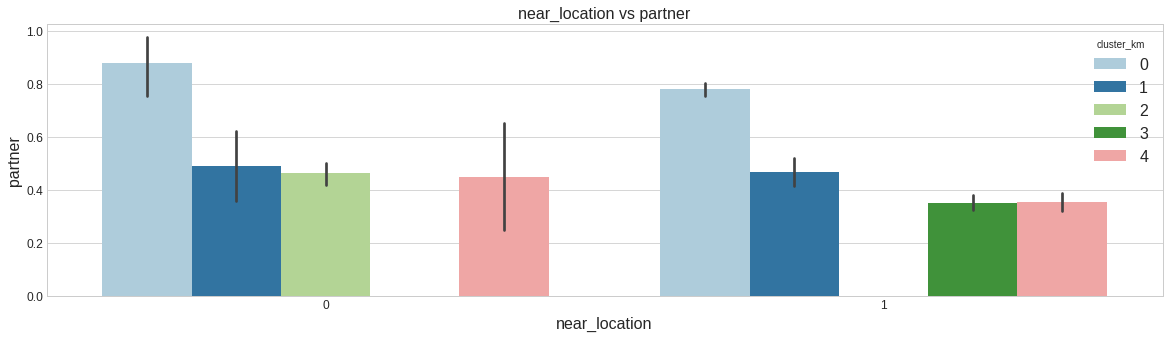

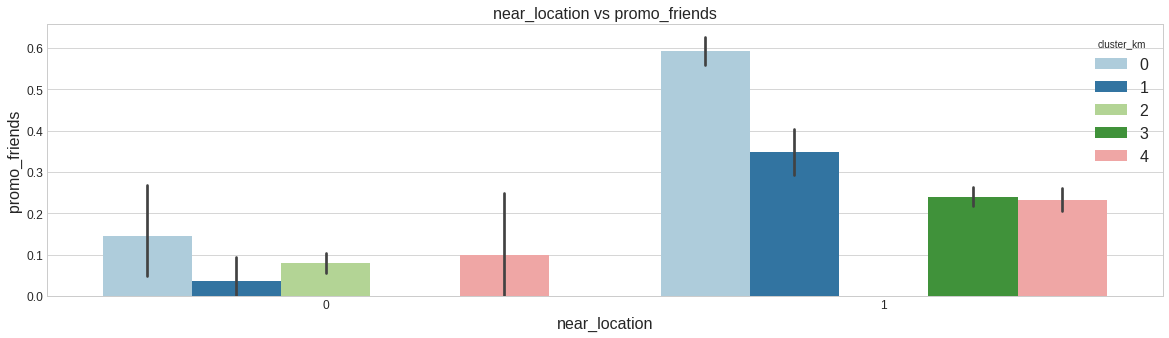

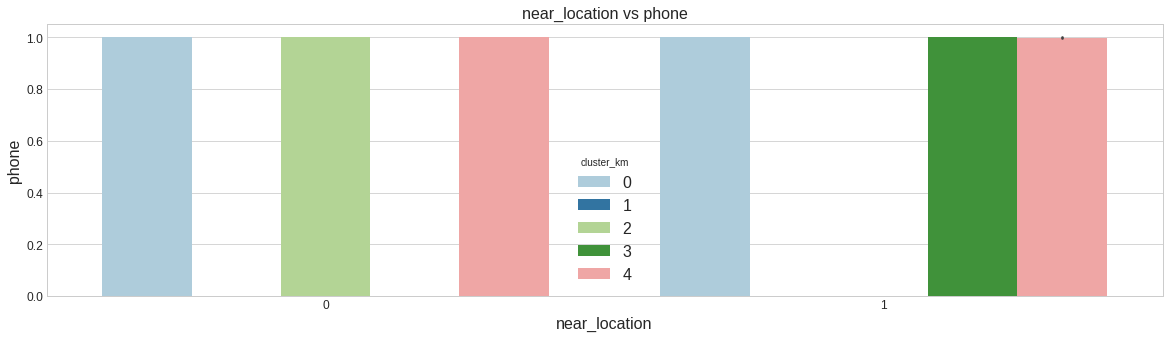

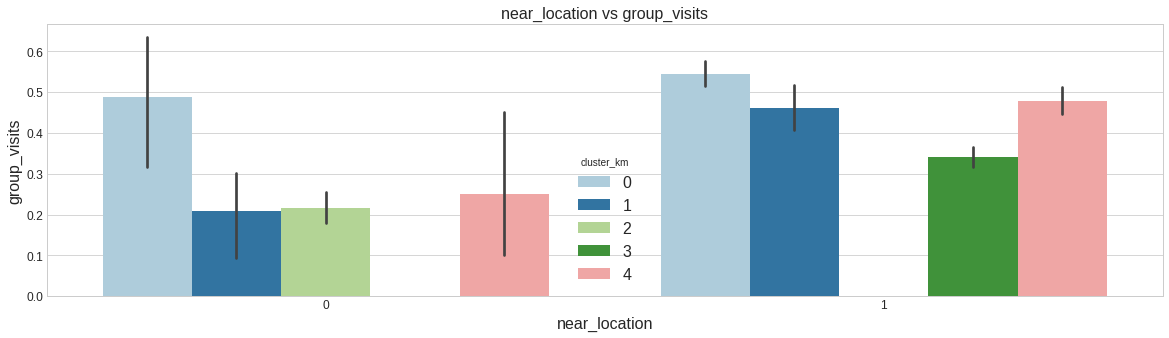

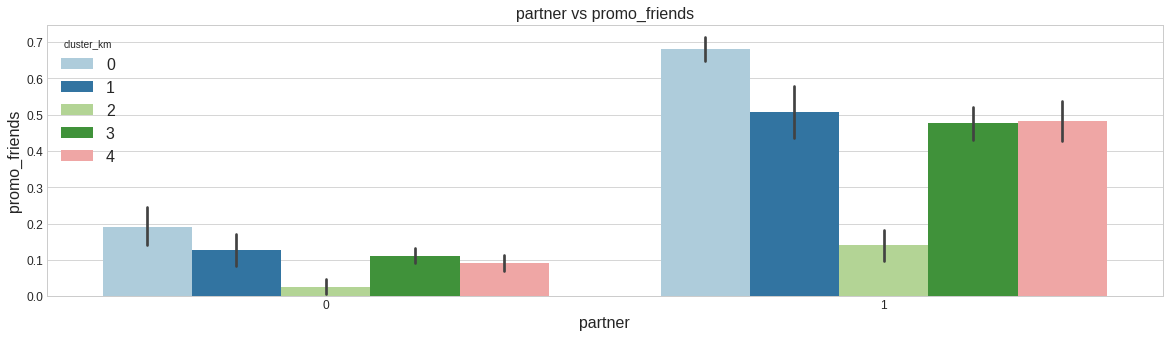

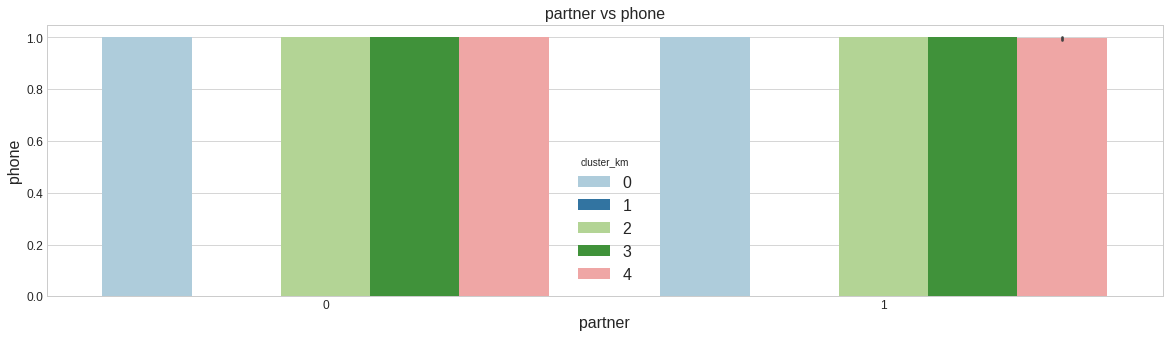

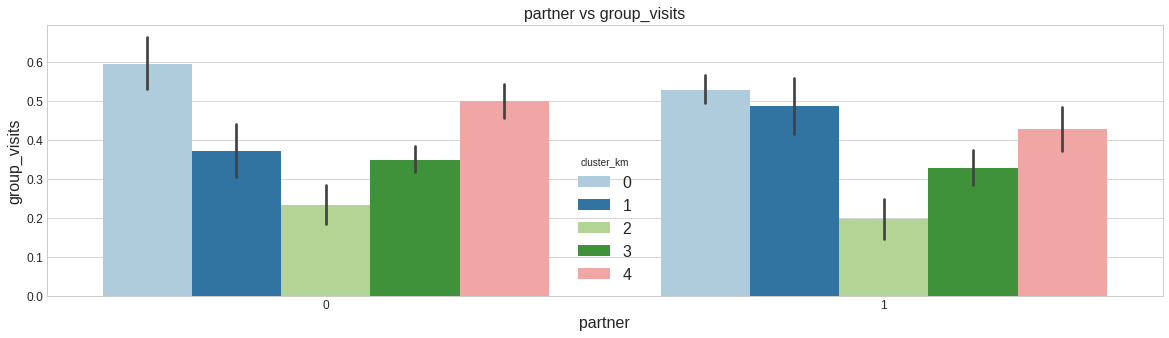

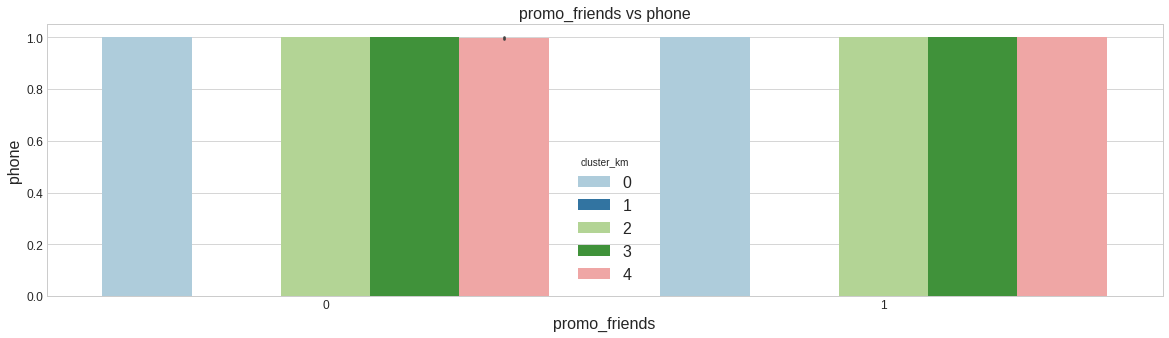

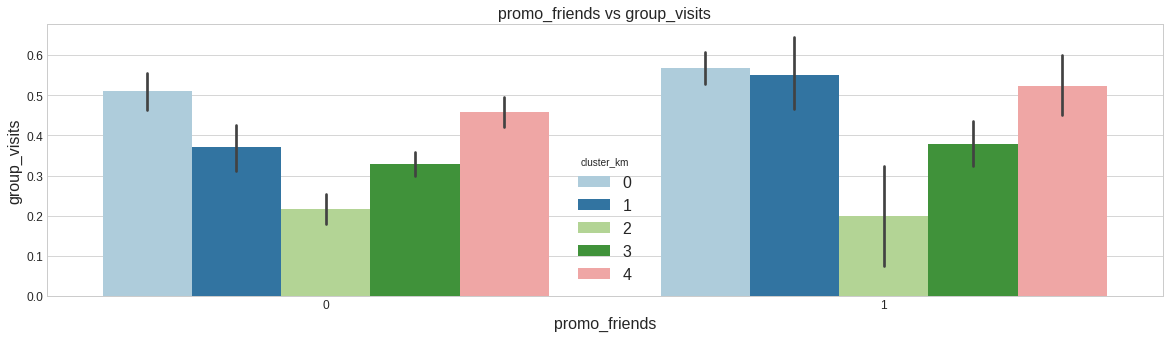

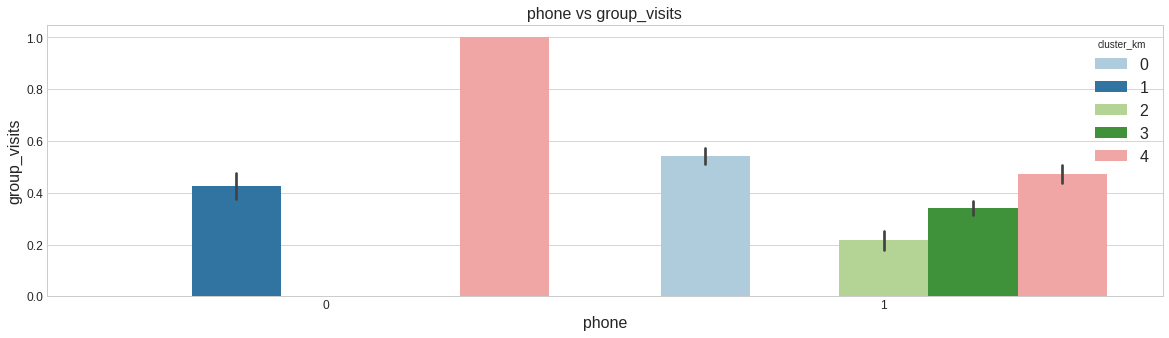

In [26]:
# графики  попарных сочетаний категориальных признаков с разметкой по кластерам
data_cat = data[category]
col_pairs = list(itertools.combinations(data_cat.columns, 2))
for pair in col_pairs:
    show_clusters_on_plot_сat(data, pair[0], pair[1], 'cluster_km')

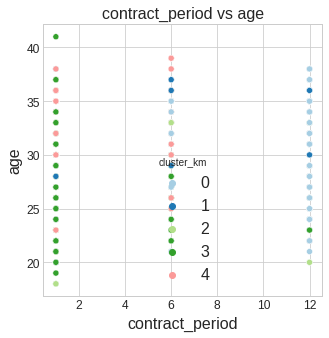

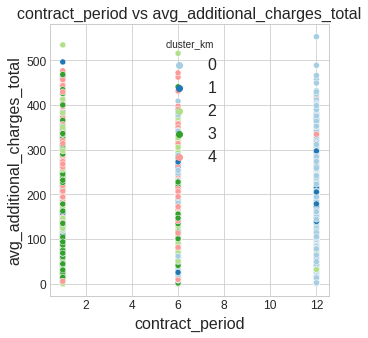

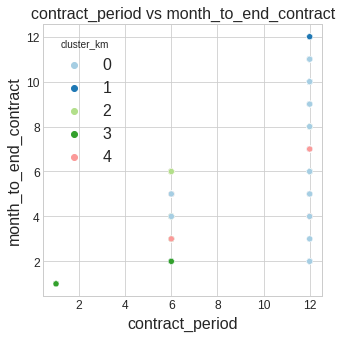

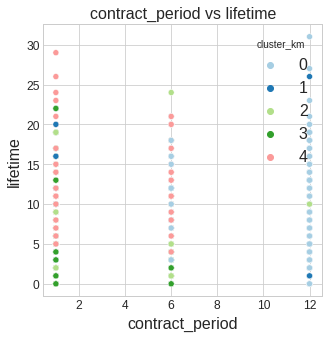

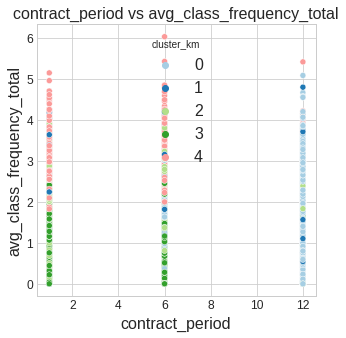

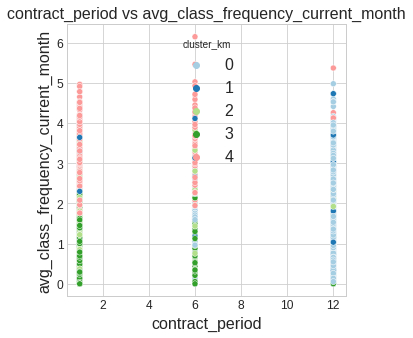

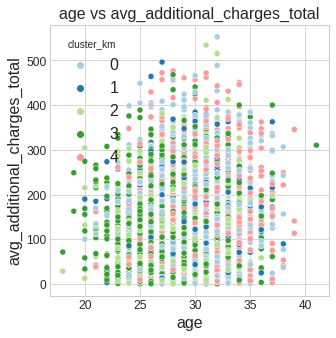

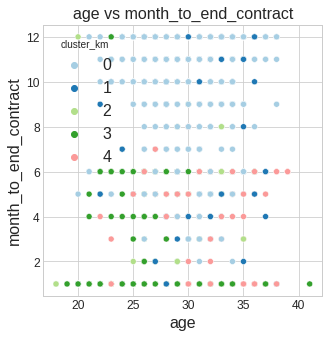

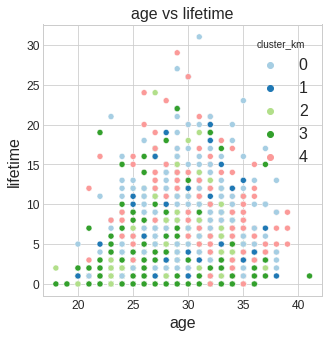

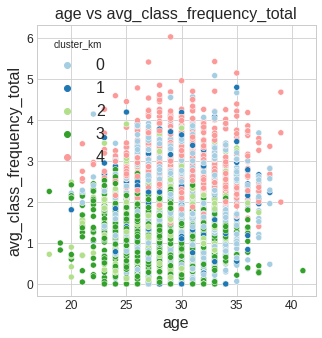

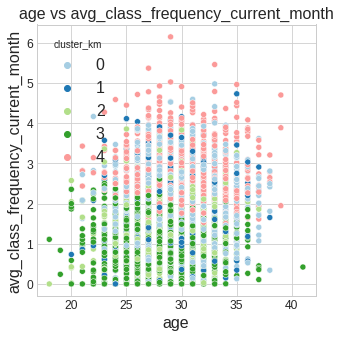

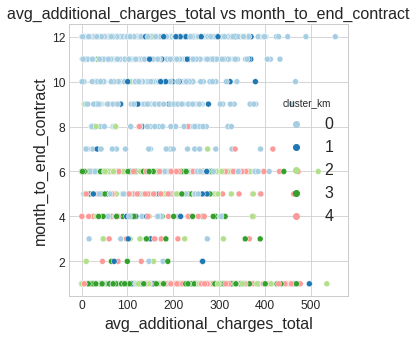

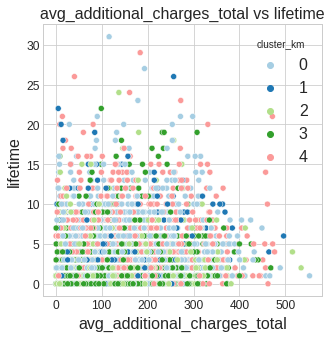

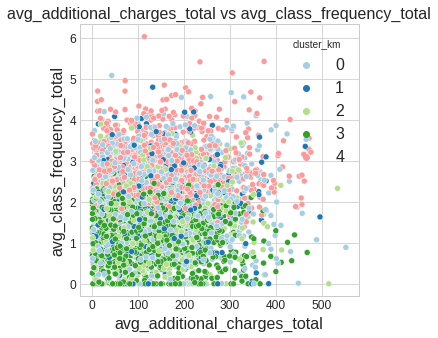

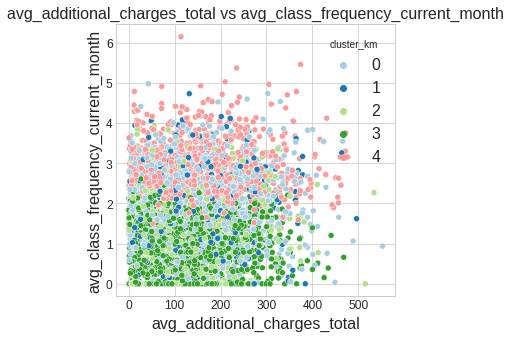

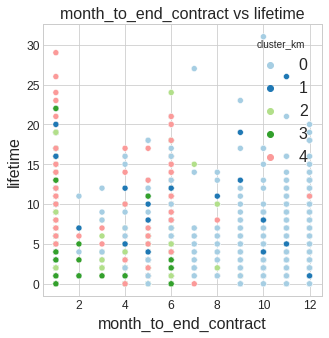

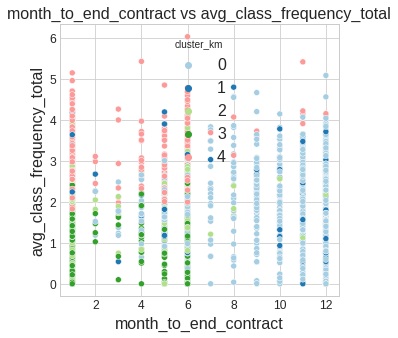

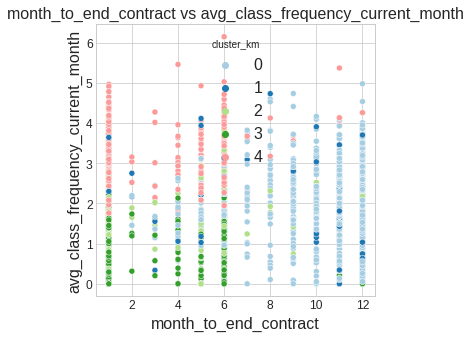

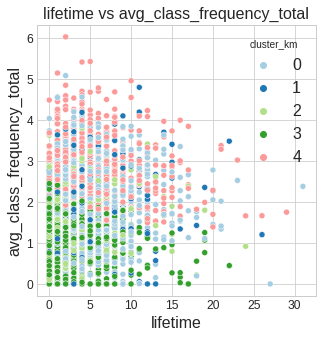

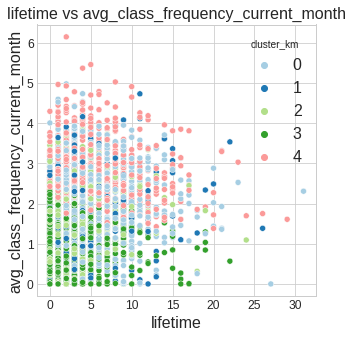

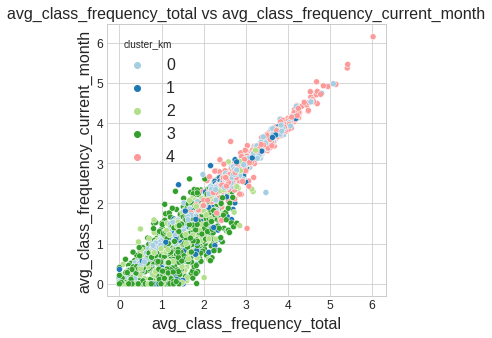

In [27]:
# графики  попарных сочетаний числовых признаков
data_num = data[numeric]
col_pairs = list(itertools.combinations(data_num.columns, 2))
for pair in col_pairs:
    show_clusters_on_plot(data, pair[0], pair[1], 'cluster_km')

**Вывод**:

1. В кластере 3 присутствует максимальный отток - 51%, в кластере 2 процент оттока - 44%.
2.  Минимальный отток в кластере 1 - 2% и кластере 4 - 6%.
3. В кластере 3 с максимальным оттоком все клиенты имеют признак 1 по близости проживания, имеют минимальную долю работающих в компаниях-партнерах, минимальный средний период контракта 1,9 мес.
4. В кластерах с максимальным оттоком 2 и 3 наименьшее количество клиентов участвующих в групповых занятиях, наименьший средний возраст, наименьшая выручка от сопуствующих услуг, минимальная частота посещения занятий и минимальное среднее время с начала посещений.

In [28]:
# расчет доли оттока для каждого кластера
out_data = data.groupby('cluster_km').agg({'churn':['mean', 'count']})
out_data = out_data.rename(columns={'churn':'Сводная таблица'}, level=0)
out_data = out_data.rename(columns={'mean':'% оттока', 'count':'Количество клиентов'}, level=1)
out_data.index = out_data.index.rename('Кластер')
out_data.style.format({('Сводная таблица', '% оттока'):'{:.2%}'})

**Выводы**: 0 и 4 кластеры самые надежные, 3 и 2 склонны к максиальному оттоку. При этом наибольшая доля клиентов приходится на 3 кластер (1262).

<a id='id_5'></a>
## Выводы и рекомендации по работе с клиентами

Общие выводы:
1. Пропущенных данных в представленных сведениях нет, общее количество клиентов за анализируемый период - 4000.
2. Средние характеристики клиентов: гендерных различий нет, 85% клиентов живут поблизости, почти половина клиентов работает в компаниях-партнерах, 30% пришли по рекомендации друзей, 90% оставили контактный телефон, средний период контракта составляет 4,7 месяцав, 40% посещают групповые занятия, средний возраст 29 лет (ст.откл. 3года), средний доход от сопутствующих услуг 147 т.р. (ст.откл. 96 т.р.), средний период до окончания контракта 4 мес. (ст.откл. 4 мес.), средний период жизни клиента 3,7 мес. (ст.откл.3.7 месо.), среднее число посещений в неделю 1,9 раза (ст.откл 1), среднее число посещений в неделю в пред.месяце 1,8 раза (ст.откл 1.1), отток текущего месяца 27%.
3. Средние характеристики группы ушедших клиентов: среди ушедших клиентов на 10% больше доля живущих в отдаленных районах, на 17% меньше работающих в компаниях-партнерах или пришедших по рекомендациям друзей, на 19% меньше посещающих групповые занятия. Расходы на сопутствующие услуги у ушедших на 17% меньше, средний период жизни ушедшего клиента 1 месяц против 4,7 у оствшихся, среднее количество посещений в неделю 1,5 против 2 у оставшихся, в последний месяц 1 против 2 у оставшихся.
4. Выявлена положительная корреляция между количеством месяцев до окончания контракта и периодом контракта, а также между средней частой посещения занятий и средней частотой посещения занятий за предыдущий месяц. Существенная отрицательная корреляция наблюдается между показателями оттока и периодом посещения занятий, частотой посещения заниятий, возрастом и контрактным периодом.
5. Среди клиентов выделены 5 основных кластеров:

  5.1. В кластере 3 присутствует максимальный отток - 51%, в кластере 2 процент оттока - 44%. Минимальный отток в кластере 1 - 2% и кластере 4 - 6%.
  
  5.2 В кластере 3 с максимальным оттоком все клиенты имеют признак 1 по близости проживания, имеют минимальную долю работающих в компаниях-партнерах, минимальный средний период контракта 1,9 мес.
  
  5.3. В кластерах с максимальным оттоком 2 и 3 наименьшее количество клиентов участвующих в групповых занятиях, наименьший средний возраст, наименьшая выручка от сопуствующих услуг, минимальная частота посещения занятий и минимальное среднее время с начала посещений.
  
**Основные рекомендации**:  

Разработать план мероприятий по продвижению услуг способствующих снижению оттока клиентов:

- участие в групповых занятиях (пример: скидки для новых клиентов)
- использование долгосрочных контрактов (пример: повышение скидки при больших сроках)
- заключение партнерских договоров с компаниями
- стимулирование 2-3 разовых посещений в неделю (пример: разработка индивидуального плана-графика занятий)
- продвижение дополнительных услуг (пример: скидочные накопительные карты)
- использовать СМС-оповщение о маркетинговых акциях, а также для напоминания о следующем занятии
